<a href="https://colab.research.google.com/github/viet4777/MSE3030/blob/main/MSE3030_2025_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# @title Chạy đầu tiên để cài thư viện
!pip install --quiet mp_api

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.6/55.6 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.8/298.8 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.9/51.9 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 64.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 96.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.3/332.3 kB 27.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.4/127.4 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.4/46.4 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 8.5 MB/s eta 0:00:00
   ━

In [7]:
# @title Giao diện thực hiện
import ipywidgets as widgets
from IPython.display import display, clear_output
from mp_api.client import MPRester
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from pymatgen.analysis.diffraction.xrd import XRDCalculator
import pandas as pd
import numpy as np

# Tạo các widget
tab = widgets.Tab()
api_key_input = widgets.Password(description="API Key:", layout=widgets.Layout(width="400px"))

# Tab 1: Tìm kiếm theo công thức
formula_input = widgets.Text(description="Công thức:", value="ZnFe2O4", layout=widgets.Layout(width="300px"))
search_button = widgets.Button(description="🔍 Tìm kiếm", button_style="primary")
download_button = widgets.Button(description="📥 Tải CSV", button_style="success")

# Tab 2: Tìm kiếm theo Material ID
material_id_input = widgets.Text(description="Material ID:", value="mp-134", layout=widgets.Layout(width="300px"))
search_id_button = widgets.Button(description="🔍 Tìm theo ID", button_style="info")

# Slider cho khoảng 2θ
theta_range_slider = widgets.IntRangeSlider(
    value=[20, 100],
    min=0,
    max=180,
    step=1,
    description='Khoảng 2θ (°):',
    continuous_update=False,
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='300px')
)

theta_range_label = widgets.Label(value="Chọn khoảng góc 2θ từ 0° đến 180°")

detail_output = widgets.Output()

# Output và progress chung
output_area = widgets.Output()
progress = widgets.IntProgress(value=0, min=0, max=100, description='Đang xử lý:', style={'bar_color': '#28a745'})

# Biến toàn cục để lưu kết quả
current_results = []

# Hàm tìm kiếm theo công thức
def on_search_button_clicked(b):
    global current_results
    output_area.clear_output()
    progress.value = 0

    API_KEY = api_key_input.value.strip()
    formula = formula_input.value.strip()

    if not API_KEY:
        with output_area:
            print("❌ Vui lòng nhập API Key trong Tab 3")
        return

    if not formula:
        with output_area:
            print("❌ Vui lòng nhập công thức hóa học")
        return

    with output_area:
        print("🔄 Đang kết nối đến Materials Project...")
        progress.value = 30

        try:
            with MPRester(API_KEY) as mpr:
                progress.value = 60
                print("🔍 Đang tìm kiếm dữ liệu...")

                # Xác định loại tìm kiếm
                search_formula = formula.strip()

                if '-' in search_formula:
                    print(f"🔍 Tìm kiếm hệ nguyên tố: {search_formula}")
                    # Tìm kiếm hệ nguyên tố
                    docs = mpr.materials.summary.search(
                        chemsys=search_formula,  # Sử dụng 'chemsys' thay vì 'formula' cho hệ nguyên tố
                        fields=["formula_pretty", "material_id", "symmetry",
                                "density", "density_atomic", "volume", "formation_energy_per_atom",
                                "energy_above_hull", "is_stable"]
                    )
                else:
                    print(f"🔍 Tìm kiếm công thức: {search_formula}")
                    # Tìm kiếm công thức chính xác hoặc nguyên tố đơn
                    docs = mpr.materials.summary.search(
                        formula=search_formula,
                        fields=["formula_pretty", "material_id", "symmetry",
                                "density", "density_atomic", "volume", "formation_energy_per_atom",
                                "energy_above_hull", "is_stable"]
                    )

                progress.value = 90
                current_results = list(docs) if docs else []

                if not current_results:
                    print(f"❌ Không tìm thấy kết quả nào cho công thức {formula}")
                else:
                    print(f"✅ Tìm thấy {len(current_results)} kết quả cho {formula}:")
                    print("=" * 150)
                    headers = ["STT", "Công thức", "Material ID", "Hệ tinh thể", "Hệ Bravais", "Nhóm điểm", "Nhóm KG", "Số", "Tỷ trọng", "Năng lượng"]
                    print(f"{headers[0]:<4} {headers[1]:<12} {headers[2]:<20} {headers[3]:<15} {headers[4]:<12} {headers[5]:<12} {headers[6]:<10} {headers[7]:<5} {headers[8]:<8} {headers[9]:<12}")
                    print("-" * 150)

                    for i, doc in enumerate(current_results, 1):
                        symmetry = doc.symmetry
                        if symmetry:
                            crystal_system = str(symmetry.crystal_system)
                            bravais_lattice = symmetry.symbol[0]
                            point_group = symmetry.point_group
                            space_group = symmetry.symbol
                            space_group_num = symmetry.number
                            density = f"{doc.density:.2f}" if doc.density else "N/A"
                            energy = f"{doc.formation_energy_per_atom:.3f}" if doc.formation_energy_per_atom else "N/A"
                        else:
                            crystal_system = bravais_lattice = point_group = space_group = space_group_num = density = energy = 'N/A'

                        print(f"{i:<4} {doc.formula_pretty:<12} {doc.material_id:<20} "
                              f"{crystal_system:<15} {bravais_lattice:<12} {point_group:<12} {space_group:<10} {space_group_num:<5} {density:<8} {energy:<12}")

                    print("=" * 150)

                    # Hiển thị bảng chú giải
                    print("\n📊 CHÚ GIẢI:")
                    bravais_explanation = {
                        'P': 'Primitive (Đơn giản)',
                        'I': 'Body-centered (Tâm khối)',
                        'F': 'Face-centered (Tâm mặt)',
                        'C': 'Base-centered (Tâm đáy)',
                        'R': 'Rhombohedral (Ba phương)',
                        'A': 'Base-centered A',
                        'B': 'Base-centered B'
                    }

                    for code, meaning in bravais_explanation.items():
                        print(f"  {code}: {meaning}")

                progress.value = 100

        except Exception as e:
            progress.value = 0
            print(f"❌ Lỗi khi truy vấn Materials Project: {e}")

# Hàm tìm kiếm theo Material ID
def on_search_id_button_clicked(b):
    detail_output.clear_output()
    progress.value = 0

    API_KEY = api_key_input.value.strip()
    material_id = material_id_input.value.strip()
    theta_min, theta_max = theta_range_slider.value

    if not API_KEY:
        with detail_output:
            print("❌ Vui lòng nhập API Key trong Tab 3")
        return

    if not material_id:
        with detail_output:
            print("❌ Vui lòng nhập Material ID")
        return

    with detail_output:
        print("🔄 Đang kết nối đến Materials Project...")
        progress.value = 30

        try:
            with MPRester(API_KEY) as mpr:
                progress.value = 60
                print("🔍 Đang lấy thông tin chi tiết...")

                # Lấy thông tin chi tiết theo material_id
                doc = mpr.materials.summary.search(material_ids=[material_id])[0]

                progress.value = 90

                if doc:
                    symmetry = doc.symmetry
                    structure = doc.structure
                    # Phân tích đối xứng (dựa trên spglib)
                    sga = SpacegroupAnalyzer(structure) #, symprec=1e-3, angle_tolerance=5)
                    # 1) Ô nguyên thủy chuẩn hoá (primitive standard) – thường có α=β=γ=60° cho fcc
                    s_prim = sga.get_primitive_standard_structure()

                    # 2) Ô chuẩn thông thường (conventional standard) – lập phương với α=β=γ=90°
                    s_conv = sga.get_conventional_standard_structure()
                    dataset = sga.get_symmetry_dataset()

                    print("=" * 80)
                    print(f"📊 THÔNG TIN CHI TIẾT CHO {material_id}")
                    print("=" * 80)

                    print(f"\n🧪 THÔNG TIN CƠ BẢN:")
                    print(f"  • Công thức: {doc.formula_pretty}")
                    print(f"  • Material ID: {doc.material_id}")
                    print(f"  • Tỷ trọng: {doc.density:.4f} g/cm³")
                    if hasattr(doc, 'formation_energy_per_atom') and doc.formation_energy_per_atom:
                        print(f"  • Năng lượng hình thành: {doc.formation_energy_per_atom:.4f} eV/atom")
                    if hasattr(doc, 'energy_above_hull') and doc.energy_above_hull:
                        print(f"  • Năng lượng trên hull: {doc.energy_above_hull:.4f} eV/atom")

                    print(f"\n🏛️ THÔNG TIN TINH THỂ HỌC:")
                    if symmetry:
                        print(f"  • Hệ tinh thể: {symmetry.crystal_system}")
                        print(f"  • Nhóm không gian: {symmetry.symbol} (số {symmetry.number})")
                        print(f"  • Nhóm điểm: {symmetry.point_group}")
                        print(f"  • Hệ Bravais: {symmetry.symbol[0]}")

                        if symmetry.hall:
                            print(f"  • Ký hiệu Hall: {symmetry.hall}")
                        elif dataset.hall:
                            print(f"  • Ký hiệu Hall: {dataset.hall}")

                    print(f"\n📐 THÔNG SỐ MẠNG TINH THỂ:")
                    if structure:
                        print(f"  • Các thông số mạng:")
                        print(f"    a = {s_conv.lattice.a:.4f} Å")
                        print(f"    b = {s_conv.lattice.b:.4f} Å")
                        print(f"    c = {s_conv.lattice.c:.4f} Å")
                        print(f"    α = {s_conv.lattice.alpha:.4f}°")
                        print(f"    β = {s_conv.lattice.beta:.4f}°")
                        print(f"    γ = {s_conv.lattice.gamma:.4f}°")
                        print(f"  • Số nguyên tử: {s_conv.num_sites}")
                        print(f"  • Thể tích: {s_conv.volume:.4f} Å³")

                        print(f"\n🧮 THÔNG SỐ MẠNG ĐẦY ĐỦ:")
                        print(f"  • Ma trận mạng:")
                        for i, vec in enumerate(s_conv.lattice.matrix):
                            print(f"    [{vec[0]:8.4f} {vec[1]:8.4f} {vec[2]:8.4f}]")

                        print(f"\n  • Các vị trí nguyên tử:")
                        for i, site in enumerate(s_conv[:10]):  # Hiển thị 10 site đầu
                            species_str = ", ".join([str(spec.symbol) for spec in site.species])
                            print(f"    {i+1}. {species_str} tại [{site.a:.4f}, {site.b:.4f}, {site.c:.4f}]")

                        if s_conv.num_sites > 10:
                            print(f"    ... và {s_conv.num_sites - 10} vị trí khác")

                    # BỔ SUNG: DANH SÁCH CÁC PEAK NHIỄU XẠ
                    print(f"\n📈 DANH SÁCH CÁC PEAK NHIỄU XẠ (XRD):")
                    print(f"  • Khoảng 2θ được chọn: {theta_min}° - {theta_max}°")
                    try:
                        # Tạo máy tính XRD với bức xạ Cu K-alpha
                        xrd_calculator = XRDCalculator(wavelength='CuKa')
                        pattern = xrd_calculator.get_pattern(s_conv, two_theta_range=(theta_min, theta_max))

                        if pattern and len(pattern.x) > 0:
                            print(f"  • Số peak nhiễu xạ: {len(pattern.x)}")
                            print(f"  • Các peak chính:")
                            print(f"    {'2θ (°)':<7} {'Cường độ':<9} {'hkl':<7} {'d (Å)':<10} {'Multiplicity':<12}")
                            print(f"    {'-'*7} {'-'*9} {'-'*7} {'-'*10} {'-'*12}")

                            # Hiển thị tất cả các peak trong khoảng đã chọn
                            for i in range(len(pattern.x)):
                                hkl_str = "".join(str(h) for h in pattern.hkls[i][0]['hkl'])
                                hkl_str = '('+ hkl_str +')'
                                multiplicity = pattern.hkls[i][0]['multiplicity']
                                print(f"    {pattern.x[i]:<7.2f} {pattern.y[i]:<9.1f} {hkl_str:<7} {pattern.d_hkls[i]:<10.4f} {multiplicity:<12}")

                            # Thông tin về peak mạnh nhất
                            max_intensity_idx = np.argmax(pattern.y)
                            max_hkl = "".join(str(h) for h in pattern.hkls[max_intensity_idx][0]['hkl'])
                            max_multiplicity = pattern.hkls[max_intensity_idx][0]['multiplicity']

                            print(f"\n  • Peak mạnh nhất trong khoảng {theta_min}°-{theta_max}°:")
                            print(f"    - 2θ = {pattern.x[max_intensity_idx]:.2f}°")
                            print(f"    - Cường độ tương đối: {pattern.y[max_intensity_idx]:.1f}")
                            print(f"    - Mặt phẳng: ({max_hkl})")
                            print(f"    - Khoảng cách d: {pattern.d_hkls[max_intensity_idx]:.4f} Å")
                            print(f"    - Bội số: {max_multiplicity}")

                            # Thống kê
                            strong_peaks = len([y for y in pattern.y if y > 50])
                            medium_peaks = len([y for y in pattern.y if 10 < y <= 50])
                            weak_peaks = len([y for y in pattern.y if y <= 10])

                            print(f"\n  • Thống kê cường độ peak:")
                            print(f"    - Peak mạnh (I > 50): {strong_peaks}")
                            print(f"    - Peak trung bình (10 < I ≤ 50): {medium_peaks}")
                            print(f"    - Peak yếu (I ≤ 10): {weak_peaks}")

                        else:
                            print(f"  • Không có peak nhiễu xạ nào trong khoảng {theta_min}°-{theta_max}°")
                            print(f"  • 💡 Thử mở rộng khoảng 2θ để xem thêm peak")

                    except Exception as xrd_error:
                        print(f"  • Không thể tính toán pattern nhiễu xạ: {xrd_error}")

                    print(f"\n📋 TÓM TẮT PHÂN LOẠI:")
                    if symmetry:
                        bravais_map = {
                            'P': 'Primitive (Đơn giản)',
                            'I': 'Body-centered (Tâm khối)',
                            'F': 'Face-centered (Tâm mặt)',
                            'C': 'Base-centered (Tâm đáy)',
                            'R': 'Rhombohedral (Ba phương)'
                        }
                        bravais_type = bravais_map.get(symmetry.symbol[0], symmetry.symbol[0])

                        print(f"  • 7 hệ tinh thể: {symmetry.crystal_system}")
                        print(f"  • 14 hệ Bravais: {bravais_type}")
                        print(f"  • 32 nhóm điểm: {symmetry.point_group}")
                        print(f"  • 230 nhóm không gian: {symmetry.symbol} (số {symmetry.number})")
                        print(f"  • 530 nhóm Hall: {dataset.hall}")

                else:
                    print(f"❌ Không tìm thấy thông tin cho Material ID: {material_id}")

                progress.value = 100

        except Exception as e:
            progress.value = 0
            print(f"❌ Lỗi khi truy vấn Materials Project: {e}")

# Hàm cập nhật nhãn slider
def update_slider_label(change):
    theta_min, theta_max = change['new']
    theta_range_label.value = f"Khoảng 2θ được chọn: {theta_min}° - {theta_max}°"

# Gán sự kiện cho slider
theta_range_slider.observe(update_slider_label, names='value')

# Hàm tải CSV
def on_download_button_clicked(b):
    if not current_results:
        with output_area:
            print("❌ Không có dữ liệu để tải xuống. Vui lòng tìm kiếm trước.")
        return

    with output_area:
        try:
            # Chuẩn bị dữ liệu cho CSV
            data = []
            for doc in current_results:
                symmetry = doc.symmetry
                row = {
                    'formula': doc.formula_pretty,
                    'material_id': doc.material_id,
                    'density': doc.density,
                    'volume': doc.volume,
                    'formation_energy_per_atom': doc.formation_energy_per_atom,
                    'crystal_system': str(symmetry.crystal_system) if symmetry else 'N/A',
                    'bravais_system': symmetry.symbol[0] if symmetry else 'N/A',
                    'point_group': symmetry.point_group if symmetry else 'N/A',
                    'space_group': symmetry.symbol if symmetry else 'N/A',
                    'space_group_number': symmetry.number if symmetry else 'N/A'
                }
                data.append(row)

            # Tạo DataFrame và lưu CSV
            df = pd.DataFrame(data)
            csv_filename = f"materials_{formula_input.value}.csv"
            df.to_csv(csv_filename, index=False)

            print(f"✅ Đã lưu dữ liệu vào file: {csv_filename}")
            print(f"📁 File chứa {len(data)} bản ghi")

        except Exception as e:
            print(f"❌ Lỗi khi tải CSV: {e}")

# Gán sự kiện
search_button.on_click(on_search_button_clicked)
search_id_button.on_click(on_search_id_button_clicked)
download_button.on_click(on_download_button_clicked)

# Tạo layout cho các tab
tab1_content = widgets.VBox([
    widgets.HTML("<h3>🔍 Tìm kiếm theo công thức</h3>"),
    widgets.HBox([formula_input, search_button, download_button]),
    progress,
    output_area
])

tab2_content = widgets.VBox([
    widgets.HTML("<h3>📊 Tìm kiếm theo Material ID</h3>"),
    widgets.HTML("<p>Nhập Material ID (ví dụ: mp-134 cho Aluminium)</p>"),
    widgets.HBox([material_id_input, search_id_button]),
    widgets.VBox([
        theta_range_label,
        theta_range_slider
    ]),
    progress,
    detail_output
])

tab3_content = widgets.VBox([
    widgets.HTML("<h3>⚙️ Cài đặt API Key</h3>"),
    widgets.HTML("<p>Lấy API Key miễn phí từ: <a href='https://next-gen.materialsproject.org/api' target='_blank'>Materials Project</a></p>"),
    api_key_input,
    widgets.HTML("""
    <div style='background: #f8f9fa; padding: 10px; border-radius: 5px; margin-top: 10px;'>
        <p style='color: #666; font-size: 12px; margin: 0;'>
        💡 <strong>Hướng dẫn:</strong><br>
        1. Truy cập <a href='https://next-gen.materialsproject.org/api' target='_blank'>Materials Project</a><br>
        2. Đăng ký tài khoản miễn phí<br>
        3. Vào Dashboard để lấy API Key<br>
        4. Dán API Key vào ô trên
        </p>
    </div>
    """)
])

# Gán nội dung cho tab
tab.children = [tab1_content, tab2_content, tab3_content]
tab.set_title(0, '🔍 Theo công thức')
tab.set_title(1, '📊 Theo ID')
tab.set_title(2, '⚙️ API Key')

# Hiển thị giao diện
display(tab)

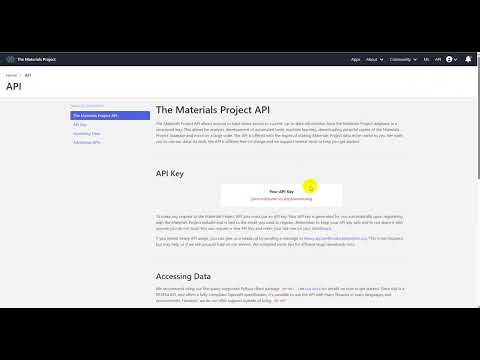

In [6]:
# @title Video hướng dẫn
from IPython.display import YouTubeVideo
# Thay “VIDEO_ID” bằng phần sau “?v=” trong URL YouTube
YouTubeVideo('-N82ngbn108', width=1000, height=600)

#Ký hiệu tinh thể học

## Bảy (07) hệ tinh thể (crystal systems)

1. Triclinic – tam nghiêng
2. Monoclinic – đơn nghiêng
3. Orthorhombic – trực thoi
4. Tetragonal – bốn phương
5. Trigonal (Rhombohedral) – ba phương (hình thoi)
6. Hexagonal – lục phương
7. Cubic – lập phương

---

## Mười bốn (14) mạng Bravais

* **Triclinic:** P
* **Monoclinic:** P, C (hoặc A/B/C-centered)
* **Orthorhombic:** P, C, I, F
* **Tetragonal:** P, I
* **Trigonal (R):** R
* **Hexagonal:** P
* **Cubic:** P, I, F

(Ghi chú các kiểu tâm: P-nguyên, I-tâm khối, F-tâm mặt, A/B/C-tâm đáy, R-rhombohedral.)

---

## Ba mươi hai (32) nhóm điểm (point groups, ký hiệu quốc tế)

- **Triclinic (2):** 1, $\bar{1}$
- **Monoclinic (3):** 2, m, 2/m
- **Orthorhombic (3):** 222, mm2, mmm
- **Tetragonal (7):** 4, $\bar{4}$, 4/m, 422, 4mm, $\bar{4}$2m, 4/mmm
- **Trigonal (5):** 3, $\bar{3}$, 32, 3m, $\bar{3}$m
- **Hexagonal (7):** 6, $\bar{6}$, 6/m, 622, 6mm, $bar{6}$m2, 6/mmm
- **Cubic (5):** 23, m$\bar{3}$, 432, $\bar{4}$3m, m$\bar{3}$m

---

# Hai trăm ba mươi (230) nhóm không gian (space groups)

* Mỗi nhóm có **số** (1–230) và **ký hiệu Hermann–Mauguin** (ví dụ: *P2₁/c*, *Fm$\bar{3}$m*, …).
* Bộ dữ liệu chuẩn (ký hiệu quốc tế, Hall symbols, …) có sẵn trong **spglib**/thư viện đối xứng, và nhiều gói như **pymatgen** hay **gemmi** đều bọc lại bảng 230 nhóm cùng các “setting/choice”. ([spglib.readthedocs.io][4])
* Danh sách đầy đủ 230 nhóm (theo số và ký hiệu) xem tổng hợp tham khảo mở này, hoặc tra trực tiếp trong International Tables: ([Wikipedia][5])

[4]: https://spglib.readthedocs.io/en/stable/dataset.html?utm_source=chatgpt.com "Spglib dataset - Read the Docs"
[5]: https://en.wikipedia.org/wiki/List_of_space_groups?utm_source=chatgpt.com "List of space groups"
